# Exploration of "Convolutional Neural Networks for Sentence Classification"


In this report, we will be experimenting with a convolutional neural network to help classify the movie reviews as either "positive" or "negative."  In particular, we will use the architecture described in "Convolutional Neural Networks for Sentence Classification" by Yoon Kim.  Prior to this paper, Convolutional Neural Networks (CNNs) had proven their worth in computer vision, where they had been used to push the state of the art in image classification.  There are at least two good reasons why CNNs proved so effective in image classification.  The first is that they are good feature extractors.  The convolution operation is useful in modeling the relationship a pixel in an image has with its neighbors.  This in turn helps the feature maps of the CNN to learn general features of images, such as edges and shapes.  Second, CNNs are parameter efficient:  each convolutional kernel is shared by the entire image.  With these benefits in mind, it is natural to ask whether CNNs can be used in natural language processing.  This paper by Kim is representative of early attempts to apply CNNs to the task of text classification.  The network presented in the paper is remarkably simple.  The first layer of the network consists of a pretrained word2vec word embedding.  The network then represents a sentence as a sequence of words as vectors from the embedding.  In the convolution layer, each kernel of size k is applied to each k-length window of words.  Therefore, for every kernel, the output of the convolution layer is 1 feature map.  Then, max pooling is performed on each feature map before they are sent through a fully-connected layer and classified.

There are two key design choices explored in the paper that we will investigate further here. The first is the use of dropout as a regularization technique.  Dropout is particularly useful in fully-connected layers where the neurons tend to become codependent.  Dropout fixes this by randomly removing a proportion p of the neurons during each iteration of training.  After experimentation, Kim discovered that p=0.5 was optimal.  We will be exploring this value as well as three others.  The second design choice of interest is the use of what Kim calls static and nonstatic learning.  In static learning, the word embedding is kept fixed, while in non-static learning, the word embedding is subject to fine tuning during gradient descent.  Kim asserts that non-static learning is better, and we will be putting this to the test on the IMDb dataset.

The report proceeds as follows.  First, we import the data and perform the necessary preprocessing.  Second, we introduce the model and its architecture.  Then, we run the network with static and non-static word representations for four different dropout probabilities (0.0, 0.25, 0.5, 0.75), resulting in 8 different networks.  Then, we discuss the training performance of each network and evaluate them on test data.  Finally, we discuss the results and present our concluding remarks.

## Data Preprocessing

Before training the models, we require two major data preprocessing steps.  First, we need to prepare the data for training. The data comes in tuples, where the first entry of the tuple is the class of the movie review (either 'pos' or 'neg'), and the second entry is a string consisting of the moview review.  Therefore, we must turn the classes into integers (0 for 'pos' and 1 for 'neg'), and we must tokenize each review so that it is a list of words.  We will keep all words (including words like 'the' and 'of'), but we will remove all punctuation.  The second step we require is constructing the word embedding.  We will be downloading the same word embedding used by Kim.  This is the word2vec embedding that was trained on Google news articles.  Then, to save memory, we will only be using the part of the embedding that is in common with the vocabulary of our dataset.  This will cut down the size of the embedding by many orders of magnitude, as the vocabulary of the dataset is relatively small.

Note as well that we wait until training and inference time to convert the list of words of each review into 2D tensors where the columns are the vector representations of each word in the review.

There are 25,000 training examples, 5,000 validation examples, and 20,000 testing examples.

In [ ]:
#Importing all libraries needed for report

import torch
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchtext import datasets
from torch.autograd import Variable
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.utils import shuffle
from gensim.models.keyedvectors import KeyedVectors
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import csv
from matplotlib import pyplot as plt

In [ ]:
#Retrieving dataset

train_data, val_test_data = datasets.IMDB(root='.data', split=('train', 'test'))

100%|██████████| 84.1M/84.1M [00:01<00:00, 60.6MB/s]


In [ ]:
def preprocessor(dataset):
    """
    Data preprocessor for pytorch IMDb dataset.
    Takes as input pytorch dataset and returns list of
    tokenized sentences and list of labels as integers
    """

    #This is the nltk tokenizer we'll use:
    tokenizer = RegexpTokenizer(r'\w+')
    #Dict for changing labels to ints
    label_to_int = {'neg': 0,
                    'pos': 1}

    token_by_sent = []
    labels = []

    for x in dataset:
        sent = x[1]
        label = label_to_int[x[0]]
        #Tokenize each sent and append to token_by_sent as list:
        token_by_sent.append(tokenizer.tokenize(sent))
        #Add label to labels list
        labels.append(label)

    sentences = []

    for x in token_by_sent:
        #Making all tokens lowercase
        sent = [word.lower() for word in x]
        #Getting rid of 'br' (token pytorch used to break up sentences)
        sent = [word for word in sent if word != 'br']
        sentences.append(sent)

    return sentences, labels

def get_tokens(sentences):
    """
    Takes list of sentences (produced in preprocessor)
    and returns single list of all tokens (with duplicates)
    """
    tokens = [w for sent in sentences for w in sent]
    return tokens

def get_max_sent(sentences):
    """
    Takes list of sentences (produced in preprocessor)
    and finds max sentence length
    """
    max_sent = 0
    for sent in sentences:
        numb_words = len(sent)
        if numb_words > max_sent:
            max_sent = numb_words
    return max_sent

def get_vocab(tokens):
    """
    Returns sorted list of tokens (no duplicates)
    """
    return sorted(list(set(tokens)))

In [ ]:

#Here is our training data
train_x, train_y = preprocessor(train_data)

#Here is our validation and test data
val_test_x, val_test_y = preprocessor(val_test_data)


In [ ]:
train_tokens = get_tokens(train_x)
val_test_tokens = get_tokens(val_test_x)
#Here is all tokens for entire dataset:
all_tokens = train_tokens + val_test_tokens

In [ ]:
# We have to split up the val_test dataset.  First
# we shuffle and then take first 5000 for val dataset

val_test_x, val_test_y = shuffle(val_test_x, val_test_y)
val_x = val_test_x[:5000]
val_y = val_test_y[:5000]
test_x = val_test_x[5000:]
test_y = val_test_y[5000:]


In [ ]:
#We will need these variables for constructing embedding and for training

MAX_SENT_LEN = max([get_max_sent(train_x), 
                    get_max_sent(val_x), 
                    get_max_sent(test_x)])
VOCAB = get_vocab(all_tokens)
VOCAB_SIZE = len(VOCAB)

In [ ]:
#Here, we retrieve the pretrained word2vec embedding used in the paper

!brew install wget

!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

/bin/bash: brew: command not found
--2022-01-26 02:59:07--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.103.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.103.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  29.8MB/s    in 40s     

2022-01-26 02:59:47 (39.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
#Unzipping file

!gzip -d GoogleNews-vectors-negative300.bin.gz

In [ ]:
 #This variable holds the downloaded word2vec representation
 
 word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [ ]:
#Dictionaries for going from words to index and vice versa
#We wlil need these for training

word_to_idx = {w: i for i, w in enumerate(VOCAB)}
idx_to_word = {i: w for i, w in enumerate(VOCAB)}

In [ ]:
#Here, we take only the vectors we need from the downloaded embedding

wv_matrix = []

for i in range(len(VOCAB)):
    word = idx_to_word[i]
    if word in word_vectors.vocab:
        #Getting vector for word in vocab if in embedding
        wv_matrix.append(word_vectors.word_vec(word))
    else:
        #If not in embedding, then we insert a random vector
        wv_matrix.append(np.random.uniform(-0.01, 0.01, 300).astype("float32"))

#We would need this vector if we encountered unknown words during inference on other datasets
wv_matrix.append(np.random.uniform(-0.01, 0.01, 300).astype("float32"))
#We need this vector for padding purposes
wv_matrix.append(np.zeros(300).astype("float32"))

wv_matrix = np.array(wv_matrix)

## The Model Architecture

We will be replicating the architecture presented in the paper.  The first layer consists of the word2vec embedding.  Here, the list of words that is each data point is converted into a tensor where the columns are the vector representations of each word.  The convolutional layer has 300 filters, 100 with window size 3, 100 with window size 4, and 100 with window size 5.  The resulting feature maps are fed through a ReLU activation function.  This is followed by a max pooling layer in which each feature map is reduced to its maximal element.  Finally, there is a fully-connected layer that takes the 300 dimensional output of the max pooling layer and projects to 2 dimensions.  Dropout is applied to the fully-connected layer during training.  Softmax can be applied to turn the output of the fully-connected layer into a probability distribution over the 2 classes.

In [ ]:
#This is a general classifcation base class that will help with training/validation
#steps and store the losses and accuracies in a list of dictionaries

class ClassificationBase(nn.Module):   
    def training_step(self, batch_x, batch_y):
        """
        Computes training loss given a batch of x data
        and labels
        """
        out = self(batch_x)
        loss = F.cross_entropy(out, batch_y)
        return loss

    def accuracy(self, outputs, labels):
        """
        Computes accuracy of predictions given outputs of model and labels
        """
        x , preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item()/len(preds))

    def validation_step(self, batch_x, batch_y):
        """
        Given batch of x data and labels, computes the validation
        loss and accuracy - stores results in dictionary
        """
        out = self(batch_x)                    
        loss = F.cross_entropy(out, batch_y)   
        acc = self.accuracy(out, batch_y)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, results):
        """
        Given list of dictionaries containing  validation 
        results of batches in epoch, returns mean results for
        epoch as dictionary
        """
        batch_losses = [x['val_loss'] for x in results]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in results]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        """
        Prints results of epoch given epoch number and epoch results dictionary
        """
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#This class defines the neural network and is built on top of the 
#classification base.  Also contains important methods for training/validating/testing

class CNN(ClassificationBase):
    def __init__(self, **kwargs):
        super(CNN, self).__init__()

        #Hyperparameters and helpful variables:

        self.BATCH_SIZE = kwargs['BATCH_SIZE']
        self.MAX_SENT_LEN = kwargs['MAX_SENT_LEN']
        self.WORD_DIM = kwargs['WORD_DIM']
        self.VOCAB_SIZE = kwargs['VOCAB_SIZE']
        self.FILTERS = kwargs['FILTERS']
        self.FILTER_NUM = kwargs['FILTER_NUM']
        self.DROPOUT_PROB = kwargs['DROPOUT_PROB']
        self.IN_CHANNEL = 1
        self.WV_MATRIX = kwargs['WV_MATRIX']
        self.EPOCHS = kwargs['EPOCHS']
        self.LEARNING_RATE = kwargs['LR']
        self.WORD_TO_IDX = kwargs['WORD_TO_IDX']
        self.CLASS_SIZE = kwargs['CLASS_SIZE']
        self.STATIC = kwargs['STATIC']
        self.OPTIMIZER = kwargs['OPTIMIZER']

        self.embedding = nn.Embedding(self.VOCAB_SIZE + 2, 
                                      self.WORD_DIM, 
                                      padding_idx=self.VOCAB_SIZE + 1)
        
        #Loading pretrained embedding:
        self.embedding.weight.data.copy_(torch.from_numpy(self.WV_MATRIX))

        #Switch to determine whether to do static or non-static learning
        #If static, then don't need gradients

        if self.STATIC == True:
            self.embedding.weight.requires_grad = False
        else:
            self.embedding.weight.requires_grad = True

        #This defines the convolutions for the convolution layer

        for i in range(len(self.FILTERS)):
            conv = nn.Conv1d(self.IN_CHANNEL, 
                             self.FILTER_NUM[i], 
                             self.WORD_DIM * self.FILTERS[i], 
                             stride=self.WORD_DIM)
            setattr(self, f'conv_{i}', conv)

        #Here is our fully-connected layer that takes the conv outputs and projets
        #to size of classes

        self.fc = nn.Linear(sum(self.FILTER_NUM), self.CLASS_SIZE)

    def get_conv(self, i):
        return getattr(self, f'conv_{i}')

    def forward(self, inp):
        x = self.embedding(inp).view(-1, 1, self.WORD_DIM * self.MAX_SENT_LEN)

        conv_results = [
            F.max_pool1d(F.relu(self.get_conv(i)(x)), 
                         self.MAX_SENT_LEN - self.FILTERS[i] + 1).view(-1, self.FILTER_NUM[i])
            for i in range(len(self.FILTERS))]

        x = torch.cat(conv_results, 1)
        x = F.dropout(x, p=self.DROPOUT_PROB, training=self.training)
        x = self.fc(x)

        return x

    def create_batch_tensors(self, x_data, y_data, batch_range, start):
        """
        Given x and y data, batch range and starting point in dataset
        returns x and y data in batches as tensor variables
        """
        batch_x = [[self.WORD_TO_IDX[w] for w in sent] +
                        [self.VOCAB_SIZE + 1] * (self.MAX_SENT_LEN - len(sent))
                        for sent in x_data[start:start + batch_range]]
        batch_y = y_data[start:start + batch_range]
        batch_x = Variable(torch.LongTensor(batch_x)).cuda()
        batch_y = Variable(torch.LongTensor(batch_y)).cuda()
        return batch_x, batch_y

    @torch.no_grad()
    def evaluate(self, val_x, val_y):
        """
        Given validation x, y data returns dictionary
        of validation loss, accuracy for epoch
        """
        self.eval()
        results = []
        for i in range(0, len(val_x), self.BATCH_SIZE):
            batch_range = min(self.BATCH_SIZE, len(val_x) - i)
            start = i
            batch_x, batch_y = self.create_batch_tensors(val_x, val_y, batch_range, start)
            out = self.validation_step(batch_x, batch_y)
            results.append(out)
        return self.validation_epoch_end(results)

    def fit(self, train_x, train_y, val_x, val_y):
        """
        Given training and validation data, returns list of dictionaries,
        one for each epoch, containing train and val loss and val accuracy
        """
        history = []
        #Define optimizer and parameters to optimize:
        optimizer = self.OPTIMIZER(self.parameters(), self.LEARNING_RATE)

        for epoch in range(self.EPOCHS):
            train_x, train_y = shuffle(train_x, train_y)
            # Training Phase 
            self.train()
            train_losses = []
            for i in range(0,len(train_x),self.BATCH_SIZE):
                batch_range = min(self.BATCH_SIZE, len(train_x) - i)
                start = i
                #Transform data into tensors for model:
                batch_x, batch_y = self.create_batch_tensors(train_x, train_y, batch_range, start)
                loss = self.training_step(batch_x, batch_y)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            # Validation phase
            result = self.evaluate(val_x, val_y)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            #Print results of epoch:
            self.epoch_end(epoch, result)
            history.append(result)
        return history

    @torch.no_grad()
    def test_results(self, x_test, y_test):
        """
        Given test data, returns confusion matrix, precision score,
        recall score, and f1 score, all computed with sklearn.metrics
        """
        self.eval()
        all_preds = []
        for i in range(0,len(x_test),self.BATCH_SIZE):
            batch_range = min(self.BATCH_SIZE, len(x_test) - i)
            start = i
            #Transform data into tensors for model:
            batch_x, batch_y = self.create_batch_tensors(x_test, y_test, batch_range, start)
            out = self(batch_x)
            _, preds = torch.max(out, dim=1)
            all_preds = all_preds + preds.tolist()
        cm = confusion_matrix(y_test, all_preds)
        prec = precision_score(y_test, all_preds)
        rec = recall_score(y_test, all_preds)
        f1 = f1_score(y_test, all_preds)
        return cm, prec, rec, f1



## Running the Model

We will be running the above architecture for 100 epochs on 4 dropout levels (0.0, 0.25, 0.5, 0.75), once with static learning and once with non-static learning.  We use a batch size of 128.  Pytorch only offers SGD and Adadelta for optimizers that are able to perform non-static learning.  We opt for Adadelta, as this seems to be standard in this domain.  Experimentation revealed 0.01 to be a reasonable learning rate.

In [ ]:
#Functions for moving tensors/model to GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

#Defining device to be used for training:
device = get_default_device()

In [34]:
#Defining the parameters for each of the 8 networks to be trained:

#Model 1: dropout=0.25 and static learning
params_1 = {'BATCH_SIZE': 128,
          'MAX_SENT_LEN': MAX_SENT_LEN,
          'WORD_DIM': 300,
          'VOCAB_SIZE': VOCAB_SIZE,
          'FILTERS': [3,4,5],
          'FILTER_NUM': [100,100,100],
          'DROPOUT_PROB': 0.25,
          'WV_MATRIX': wv_matrix,
          'EPOCHS': 100,
          'LR': 0.01,
          'WORD_TO_IDX': word_to_idx,
          'IDX_TO_WORD': idx_to_word,
          'CLASS_SIZE': 2,
          'STATIC': True,
          'OPTIMIZER': torch.optim.Adadelta}

#Model 2: dropout=0.25 and nonstatic learning
params_2 = {'BATCH_SIZE': 128,
          'MAX_SENT_LEN': MAX_SENT_LEN,
          'WORD_DIM': 300,
          'VOCAB_SIZE': VOCAB_SIZE,
          'FILTERS': [3,4,5],
          'FILTER_NUM': [100,100,100],
          'DROPOUT_PROB': 0.25,
          'WV_MATRIX': wv_matrix,
          'EPOCHS': 100,
          'LR': 0.01,
          'WORD_TO_IDX': word_to_idx,
          'IDX_TO_WORD': idx_to_word,
          'CLASS_SIZE': 2,
          'STATIC': False,
          'OPTIMIZER': torch.optim.Adadelta}

#Model 3: dropout=0.5 and static learning
params_3 = {'BATCH_SIZE': 128,
          'MAX_SENT_LEN': MAX_SENT_LEN,
          'WORD_DIM': 300,
          'VOCAB_SIZE': VOCAB_SIZE,
          'FILTERS': [3,4,5],
          'FILTER_NUM': [100,100,100],
          'DROPOUT_PROB': 0.5,
          'WV_MATRIX': wv_matrix,
          'EPOCHS': 100,
          'LR': 0.01,
          'WORD_TO_IDX': word_to_idx,
          'IDX_TO_WORD': idx_to_word,
          'CLASS_SIZE': 2,
          'STATIC': True,
          'OPTIMIZER': torch.optim.Adadelta}

#Model 4: dropout=0.5 and nonstatic learning
params_4 = {'BATCH_SIZE': 128,
          'MAX_SENT_LEN': MAX_SENT_LEN,
          'WORD_DIM': 300,
          'VOCAB_SIZE': VOCAB_SIZE,
          'FILTERS': [3,4,5],
          'FILTER_NUM': [100,100,100],
          'DROPOUT_PROB': 0.5,
          'WV_MATRIX': wv_matrix,
          'EPOCHS': 100,
          'LR': 0.01,
          'WORD_TO_IDX': word_to_idx,
          'IDX_TO_WORD': idx_to_word,
          'CLASS_SIZE': 2,
          'STATIC': False,
          'OPTIMIZER': torch.optim.Adadelta}

#Model 5: dropout=0.75 and static learning
params_5 = {'BATCH_SIZE': 128,
          'MAX_SENT_LEN': MAX_SENT_LEN,
          'WORD_DIM': 300,
          'VOCAB_SIZE': VOCAB_SIZE,
          'FILTERS': [3,4,5],
          'FILTER_NUM': [100,100,100],
          'DROPOUT_PROB': 0.75,
          'WV_MATRIX': wv_matrix,
          'EPOCHS': 100,
          'LR': 0.01,
          'WORD_TO_IDX': word_to_idx,
          'IDX_TO_WORD': idx_to_word,
          'CLASS_SIZE': 2,
          'STATIC': True,
          'OPTIMIZER': torch.optim.Adadelta}

#Model 6: dropout=0.75 and nonstatic learning
params_6 = {'BATCH_SIZE': 128,
          'MAX_SENT_LEN': MAX_SENT_LEN,
          'WORD_DIM': 300,
          'VOCAB_SIZE': VOCAB_SIZE,
          'FILTERS': [3,4,5],
          'FILTER_NUM': [100,100,100],
          'DROPOUT_PROB': 0.75,
          'WV_MATRIX': wv_matrix,
          'EPOCHS': 100,
          'LR': 0.01,
          'WORD_TO_IDX': word_to_idx,
          'IDX_TO_WORD': idx_to_word,
          'CLASS_SIZE': 2,
          'STATIC': False,
          'OPTIMIZER': torch.optim.Adadelta}

#Model 7: dropout=0.0 and static learning
params_7 = {'BATCH_SIZE': 128,
          'MAX_SENT_LEN': MAX_SENT_LEN,
          'WORD_DIM': 300,
          'VOCAB_SIZE': VOCAB_SIZE,
          'FILTERS': [3,4,5],
          'FILTER_NUM': [100,100,100],
          'DROPOUT_PROB': 0.0,
          'WV_MATRIX': wv_matrix,
          'EPOCHS': 100,
          'LR': 0.01,
          'WORD_TO_IDX': word_to_idx,
          'IDX_TO_WORD': idx_to_word,
          'CLASS_SIZE': 2,
          'STATIC': True,
          'OPTIMIZER': torch.optim.Adadelta}

#Model 8: dropout=0.0 and nonstatic learning
params_8 = {'BATCH_SIZE': 128,
          'MAX_SENT_LEN': MAX_SENT_LEN,
          'WORD_DIM': 300,
          'VOCAB_SIZE': VOCAB_SIZE,
          'FILTERS': [3,4,5],
          'FILTER_NUM': [100,100,100],
          'DROPOUT_PROB': 0.0,
          'WV_MATRIX': wv_matrix,
          'EPOCHS': 100,
          'LR': 0.01,
          'WORD_TO_IDX': word_to_idx,
          'IDX_TO_WORD': idx_to_word,
          'CLASS_SIZE': 2,
          'STATIC': False,
          'OPTIMIZER': torch.optim.Adadelta}

params = {'Model 1': params_1,
          'Model 2': params_2,
          'Model 3': params_3,
          'Model 4': params_4,
          'Model 5': params_5,
          'Model 6': params_6,
          'Model 7': params_7,
          'Model 8': params_8}

In [ ]:
#Instantiating model 1

model = CNN(**params_1)

In [ ]:
#Moving model 1 to GPU

to_device(model, torch.device('cuda'))

CNN(
  (embedding): Embedding(101945, 300, padding_idx=101944)
  (conv_0): Conv1d(1, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(1, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(1, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
#Training model 1

history_1 = model.fit(train_x, train_y, val_x, val_y)

Epoch [0], train_loss: 0.6921, val_loss: 0.6903, val_acc: 0.5816
Epoch [1], train_loss: 0.6886, val_loss: 0.6869, val_acc: 0.6191
Epoch [2], train_loss: 0.6845, val_loss: 0.6836, val_acc: 0.6412
Epoch [3], train_loss: 0.6805, val_loss: 0.6794, val_acc: 0.6666
Epoch [4], train_loss: 0.6751, val_loss: 0.6749, val_acc: 0.6900
Epoch [5], train_loss: 0.6701, val_loss: 0.6696, val_acc: 0.6877
Epoch [6], train_loss: 0.6639, val_loss: 0.6634, val_acc: 0.6988
Epoch [7], train_loss: 0.6570, val_loss: 0.6559, val_acc: 0.7076
Epoch [8], train_loss: 0.6478, val_loss: 0.6466, val_acc: 0.7199
Epoch [9], train_loss: 0.6388, val_loss: 0.6362, val_acc: 0.7311
Epoch [10], train_loss: 0.6271, val_loss: 0.6243, val_acc: 0.7480
Epoch [11], train_loss: 0.6136, val_loss: 0.6105, val_acc: 0.7602
Epoch [12], train_loss: 0.5990, val_loss: 0.5952, val_acc: 0.7697
Epoch [13], train_loss: 0.5832, val_loss: 0.5786, val_acc: 0.7879
Epoch [14], train_loss: 0.5667, val_loss: 0.5612, val_acc: 0.7963
Epoch [15], train_lo

In [ ]:
#Saving training history of model 1

keys = history_1[0].keys()
with open('history_1.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(history_1)

In [ ]:
#Saving weights dict of model 1

torch.save(model.state_dict(), '/content/model_1.pt')

In [ ]:
#Instantiating model 2

model = CNN(**params_2)

In [ ]:
#Moving model 2 to GPU

to_device(model, torch.device('cuda'))

CNN(
  (embedding): Embedding(101945, 300, padding_idx=101944)
  (conv_0): Conv1d(1, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(1, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(1, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
#Training model 2

history_2 = model.fit(train_x, train_y, val_x, val_y)

Epoch [0], train_loss: 0.6940, val_loss: 0.6894, val_acc: 0.5961
Epoch [1], train_loss: 0.6886, val_loss: 0.6855, val_acc: 0.6285
Epoch [2], train_loss: 0.6845, val_loss: 0.6813, val_acc: 0.6687
Epoch [3], train_loss: 0.6790, val_loss: 0.6766, val_acc: 0.6781
Epoch [4], train_loss: 0.6729, val_loss: 0.6711, val_acc: 0.6834
Epoch [5], train_loss: 0.6661, val_loss: 0.6647, val_acc: 0.6854
Epoch [6], train_loss: 0.6592, val_loss: 0.6570, val_acc: 0.7025
Epoch [7], train_loss: 0.6501, val_loss: 0.6477, val_acc: 0.7213
Epoch [8], train_loss: 0.6398, val_loss: 0.6367, val_acc: 0.7293
Epoch [9], train_loss: 0.6276, val_loss: 0.6238, val_acc: 0.7516
Epoch [10], train_loss: 0.6133, val_loss: 0.6093, val_acc: 0.7602
Epoch [11], train_loss: 0.5987, val_loss: 0.5936, val_acc: 0.7768
Epoch [12], train_loss: 0.5828, val_loss: 0.5766, val_acc: 0.7846
Epoch [13], train_loss: 0.5652, val_loss: 0.5591, val_acc: 0.7949
Epoch [14], train_loss: 0.5490, val_loss: 0.5415, val_acc: 0.7982
Epoch [15], train_lo

In [ ]:
#Saving training history of model 2

keys = history_2[0].keys()
with open('history_2.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(history_2)

In [ ]:
#Saving weights dict of model 2

torch.save(model.state_dict(), '/content/model_2.pt')

In [ ]:
#Instantiating model 3

model = CNN(**params_3)

In [ ]:
#Moving model 3 to GPU

to_device(model, torch.device('cuda'))

CNN(
  (embedding): Embedding(101945, 300, padding_idx=101944)
  (conv_0): Conv1d(1, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(1, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(1, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
#Training model 3

history_3 = model.fit(train_x, train_y, val_x, val_y)

Epoch [0], train_loss: 0.6957, val_loss: 0.6903, val_acc: 0.5766
Epoch [1], train_loss: 0.6910, val_loss: 0.6871, val_acc: 0.6371
Epoch [2], train_loss: 0.6877, val_loss: 0.6836, val_acc: 0.6615
Epoch [3], train_loss: 0.6833, val_loss: 0.6798, val_acc: 0.6861
Epoch [4], train_loss: 0.6782, val_loss: 0.6755, val_acc: 0.7199
Epoch [5], train_loss: 0.6729, val_loss: 0.6704, val_acc: 0.7234
Epoch [6], train_loss: 0.6685, val_loss: 0.6644, val_acc: 0.7311
Epoch [7], train_loss: 0.6613, val_loss: 0.6577, val_acc: 0.7334
Epoch [8], train_loss: 0.6542, val_loss: 0.6499, val_acc: 0.7453
Epoch [9], train_loss: 0.6473, val_loss: 0.6410, val_acc: 0.7549
Epoch [10], train_loss: 0.6372, val_loss: 0.6308, val_acc: 0.7648
Epoch [11], train_loss: 0.6265, val_loss: 0.6193, val_acc: 0.7705
Epoch [12], train_loss: 0.6151, val_loss: 0.6071, val_acc: 0.7676
Epoch [13], train_loss: 0.6014, val_loss: 0.5935, val_acc: 0.7871
Epoch [14], train_loss: 0.5910, val_loss: 0.5795, val_acc: 0.7932
Epoch [15], train_lo

In [ ]:
#Saving training results of model 3

keys = history_3[0].keys()
with open('history_3.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(history_3)

In [ ]:
#Saving weights dict of model 3

torch.save(model.state_dict(), '/content/model_3.pt')

In [ ]:
#Instantiating model 4

model = CNN(**params_4)

In [ ]:
#Moving model 4 to GPU

to_device(model, torch.device('cuda'))

CNN(
  (embedding): Embedding(101945, 300, padding_idx=101944)
  (conv_0): Conv1d(1, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(1, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(1, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
#Training model 4

history_4 = model.fit(train_x, train_y, val_x, val_y)

Epoch [0], train_loss: 0.6947, val_loss: 0.6897, val_acc: 0.5506
Epoch [1], train_loss: 0.6905, val_loss: 0.6868, val_acc: 0.6203
Epoch [2], train_loss: 0.6869, val_loss: 0.6838, val_acc: 0.6730
Epoch [3], train_loss: 0.6836, val_loss: 0.6803, val_acc: 0.6877
Epoch [4], train_loss: 0.6806, val_loss: 0.6763, val_acc: 0.7021
Epoch [5], train_loss: 0.6740, val_loss: 0.6715, val_acc: 0.7086
Epoch [6], train_loss: 0.6685, val_loss: 0.6659, val_acc: 0.7238
Epoch [7], train_loss: 0.6629, val_loss: 0.6591, val_acc: 0.7350
Epoch [8], train_loss: 0.6567, val_loss: 0.6513, val_acc: 0.7516
Epoch [9], train_loss: 0.6471, val_loss: 0.6419, val_acc: 0.7582
Epoch [10], train_loss: 0.6378, val_loss: 0.6313, val_acc: 0.7670
Epoch [11], train_loss: 0.6287, val_loss: 0.6198, val_acc: 0.7754
Epoch [12], train_loss: 0.6153, val_loss: 0.6070, val_acc: 0.7836
Epoch [13], train_loss: 0.6023, val_loss: 0.5930, val_acc: 0.7879
Epoch [14], train_loss: 0.5900, val_loss: 0.5786, val_acc: 0.7928
Epoch [15], train_lo

In [ ]:
#Saving training results of model 4

keys = history_4[0].keys()
with open('history_4.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(history_4)

In [ ]:
#Saving weight dict of model 4

torch.save(model.state_dict(), '/content/model_4.pt')

In [ ]:
#Instantiating model 5

model = CNN(**params_5)

In [ ]:
#Moving model 5 to GPU

to_device(model, torch.device('cuda'))

CNN(
  (embedding): Embedding(101945, 300, padding_idx=101944)
  (conv_0): Conv1d(1, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(1, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(1, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
#Training model 5

history_5 = model.fit(train_x, train_y, val_x, val_y)

Epoch [0], train_loss: 0.7006, val_loss: 0.6888, val_acc: 0.6043
Epoch [1], train_loss: 0.6967, val_loss: 0.6863, val_acc: 0.6492
Epoch [2], train_loss: 0.6940, val_loss: 0.6836, val_acc: 0.6658
Epoch [3], train_loss: 0.6907, val_loss: 0.6810, val_acc: 0.6723
Epoch [4], train_loss: 0.6866, val_loss: 0.6781, val_acc: 0.6777
Epoch [5], train_loss: 0.6850, val_loss: 0.6748, val_acc: 0.7158
Epoch [6], train_loss: 0.6801, val_loss: 0.6712, val_acc: 0.7260
Epoch [7], train_loss: 0.6756, val_loss: 0.6671, val_acc: 0.7268
Epoch [8], train_loss: 0.6704, val_loss: 0.6625, val_acc: 0.7484
Epoch [9], train_loss: 0.6649, val_loss: 0.6571, val_acc: 0.7549
Epoch [10], train_loss: 0.6607, val_loss: 0.6511, val_acc: 0.7637
Epoch [11], train_loss: 0.6532, val_loss: 0.6443, val_acc: 0.7688
Epoch [12], train_loss: 0.6464, val_loss: 0.6367, val_acc: 0.7768
Epoch [13], train_loss: 0.6406, val_loss: 0.6283, val_acc: 0.7883
Epoch [14], train_loss: 0.6312, val_loss: 0.6192, val_acc: 0.7916
Epoch [15], train_lo

In [ ]:
#Saving training results of model 5

keys = history_5[0].keys()
with open('history_5.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(history_5)

In [ ]:
#Saving weight dict of model 5

torch.save(model.state_dict(), '/content/model_5.pt')

In [ ]:
#Instantiating model 6

model = CNN(**params_6)

In [ ]:
#Moving model 6 to GPU

to_device(model, torch.device('cuda'))

CNN(
  (embedding): Embedding(101945, 300, padding_idx=101944)
  (conv_0): Conv1d(1, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(1, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(1, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [26]:
#Training model 6

history_6 = model.fit(train_x, train_y, val_x, val_y)

Epoch [0], train_loss: 0.7022, val_loss: 0.6900, val_acc: 0.5881
Epoch [1], train_loss: 0.6989, val_loss: 0.6872, val_acc: 0.6488
Epoch [2], train_loss: 0.6936, val_loss: 0.6843, val_acc: 0.6908
Epoch [3], train_loss: 0.6898, val_loss: 0.6813, val_acc: 0.7164
Epoch [4], train_loss: 0.6875, val_loss: 0.6780, val_acc: 0.7209
Epoch [5], train_loss: 0.6838, val_loss: 0.6742, val_acc: 0.7309
Epoch [6], train_loss: 0.6796, val_loss: 0.6699, val_acc: 0.7432
Epoch [7], train_loss: 0.6742, val_loss: 0.6651, val_acc: 0.7486
Epoch [8], train_loss: 0.6688, val_loss: 0.6596, val_acc: 0.7545
Epoch [9], train_loss: 0.6638, val_loss: 0.6534, val_acc: 0.7643
Epoch [10], train_loss: 0.6567, val_loss: 0.6464, val_acc: 0.7744
Epoch [11], train_loss: 0.6509, val_loss: 0.6388, val_acc: 0.7887
Epoch [12], train_loss: 0.6438, val_loss: 0.6305, val_acc: 0.7979
Epoch [13], train_loss: 0.6345, val_loss: 0.6212, val_acc: 0.8014
Epoch [14], train_loss: 0.6256, val_loss: 0.6111, val_acc: 0.8025
Epoch [15], train_lo

In [27]:
#Saving training results of model 6

keys = history_6[0].keys()
with open('history_6.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(history_6)

In [28]:
#Saving weight dict of model 6

torch.save(model.state_dict(), '/content/model_6.pt')

In [ ]:
#Instantiating model 7

model = CNN(**params_7)

In [ ]:
#Moving model 7 to GPU

to_device(model, torch.device('cuda'))

CNN(
  (embedding): Embedding(101945, 300, padding_idx=101944)
  (conv_0): Conv1d(1, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(1, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(1, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
#Training model 7

history_7 = model.fit(train_x, train_y, val_x, val_y)

Epoch [0], train_loss: 0.6911, val_loss: 0.6889, val_acc: 0.5791
Epoch [1], train_loss: 0.6864, val_loss: 0.6850, val_acc: 0.6623
Epoch [2], train_loss: 0.6814, val_loss: 0.6806, val_acc: 0.6826
Epoch [3], train_loss: 0.6758, val_loss: 0.6754, val_acc: 0.6936
Epoch [4], train_loss: 0.6695, val_loss: 0.6694, val_acc: 0.6945
Epoch [5], train_loss: 0.6621, val_loss: 0.6622, val_acc: 0.6963
Epoch [6], train_loss: 0.6533, val_loss: 0.6537, val_acc: 0.7029
Epoch [7], train_loss: 0.6431, val_loss: 0.6437, val_acc: 0.7135
Epoch [8], train_loss: 0.6314, val_loss: 0.6320, val_acc: 0.7281
Epoch [9], train_loss: 0.6182, val_loss: 0.6187, val_acc: 0.7414
Epoch [10], train_loss: 0.6029, val_loss: 0.6035, val_acc: 0.7574
Epoch [11], train_loss: 0.5863, val_loss: 0.5865, val_acc: 0.7664
Epoch [12], train_loss: 0.5686, val_loss: 0.5688, val_acc: 0.7824
Epoch [13], train_loss: 0.5502, val_loss: 0.5507, val_acc: 0.7910
Epoch [14], train_loss: 0.5314, val_loss: 0.5318, val_acc: 0.8010
Epoch [15], train_lo

In [ ]:
#Saving training results of model 7

keys = history_7[0].keys()
with open('history_7.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(history_7)

In [ ]:
#Saving weight dict of model 7

torch.save(model.state_dict(), '/content/model_7.pt')

In [ ]:
#Instantiating model 8

model = CNN(**params_8)

In [ ]:
#Moving model 8 to GPU

to_device(model, torch.device('cuda'))

CNN(
  (embedding): Embedding(101945, 300, padding_idx=101944)
  (conv_0): Conv1d(1, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(1, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(1, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
#Training model 8

history_8 = model.fit(train_x, train_y, val_x, val_y)

Epoch [0], train_loss: 0.6926, val_loss: 0.6887, val_acc: 0.5908
Epoch [1], train_loss: 0.6860, val_loss: 0.6848, val_acc: 0.6375
Epoch [2], train_loss: 0.6815, val_loss: 0.6806, val_acc: 0.6592
Epoch [3], train_loss: 0.6762, val_loss: 0.6755, val_acc: 0.7092
Epoch [4], train_loss: 0.6698, val_loss: 0.6690, val_acc: 0.7189
Epoch [5], train_loss: 0.6620, val_loss: 0.6612, val_acc: 0.7201
Epoch [6], train_loss: 0.6526, val_loss: 0.6518, val_acc: 0.7326
Epoch [7], train_loss: 0.6416, val_loss: 0.6404, val_acc: 0.7365
Epoch [8], train_loss: 0.6287, val_loss: 0.6274, val_acc: 0.7553
Epoch [9], train_loss: 0.6140, val_loss: 0.6123, val_acc: 0.7607
Epoch [10], train_loss: 0.5973, val_loss: 0.5954, val_acc: 0.7760
Epoch [11], train_loss: 0.5790, val_loss: 0.5772, val_acc: 0.7848
Epoch [12], train_loss: 0.5598, val_loss: 0.5576, val_acc: 0.7934
Epoch [13], train_loss: 0.5399, val_loss: 0.5380, val_acc: 0.7986
Epoch [14], train_loss: 0.5194, val_loss: 0.5187, val_acc: 0.8088
Epoch [15], train_lo

In [ ]:
#Saving training results of model 8

keys = history_8[0].keys()
with open('history_8.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(history_8)

In [ ]:
#Saving weight dict of model 8

torch.save(model.state_dict(), '/content/model_8.pt')

In [47]:
#Function to execute testing of all models

def test_models():
    df = pd.DataFrame({'Model': [],
                        'Accuracy': [],
                        'Precision Score': [],
                        'Recall Score': [],
                        'F1 Score': [],
                        'Confusion Matrix': []})

    for i in range(8):
        print('Testing model', str(i+1))
        model_name = 'Model '+ str(i+1)
        file_name = '/content/model_' + str(i+1) + '.pt'
        par = params[model_name]
        model = CNN(**par)
        model.load_state_dict(torch.load(file_name))
        to_device(model, torch.device('cuda'))
        cm, prec, rec, f1 = model.test_results(test_x, test_y)
        acc = (cm[0,0]+cm[1,1])/np.sum(cm)
        df.loc[len(df.index)] = [model_name, acc, prec, rec, f1, cm]
    return df


In [48]:
#Test all models

df_test_results = test_models()

Testing model 1


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Testing model 2
Testing model 3
Testing model 4
Testing model 5
Testing model 6
Testing model 7
Testing model 8


In [50]:
#Save test results

df_test_results.to_pickle('test_results.pkl')


## Results







In [51]:
#Lodaing training/validation results

df1 = pd.read_csv("/content/history_1.csv")
df2 = pd.read_csv("/content/history_2.csv")
df3 = pd.read_csv("/content/history_3.csv")
df4 = pd.read_csv("/content/history_4.csv")
df5 = pd.read_csv("/content/history_5.csv")
df6 = pd.read_csv("/content/history_6.csv")
df7 = pd.read_csv("/content/history_7.csv")
df8 = pd.read_csv("/content/history_8.csv")


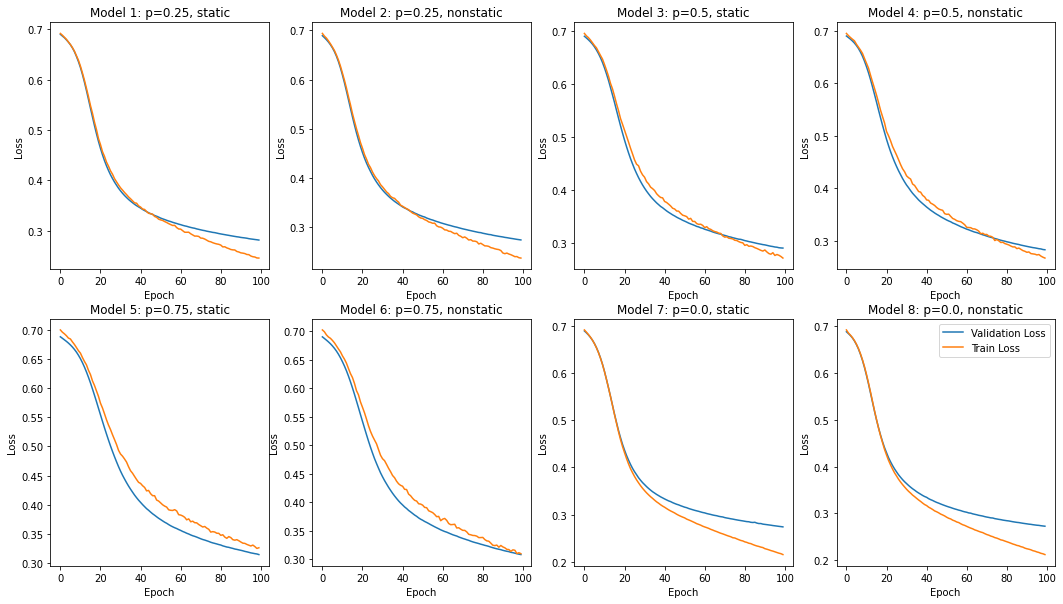

In [107]:
#Plotting validation and train loss

fig, axs = plt.subplots(2, 4, figsize=(18,10))
axs[0,0].plot(range(100), df1['val_loss'], label="Validation Loss")
axs[0,0].plot(df1['train_loss'], label="Train Loss")
axs[0,0].set_title('Model 1: p=0.25, static')
axs[0,1].plot(range(100), df2['val_loss'], label="Validation Loss")
axs[0,1].plot(df2['train_loss'], label="Train Loss")
axs[0,1].set_title('Model 2: p=0.25, nonstatic')
axs[0,2].plot(range(100), df3['val_loss'], label="Validation Loss")
axs[0,2].plot(df3['train_loss'], label="Train Loss")
axs[0,2].set_title('Model 3: p=0.5, static')
axs[0,3].plot(range(100), df4['val_loss'], label="Validation Loss")
axs[0,3].plot(df4['train_loss'], label="Train Loss")
axs[0,3].set_title('Model 4: p=0.5, nonstatic')
axs[1,0].plot(range(100), df5['val_loss'], label="Validation Loss")
axs[1,0].plot(df5['train_loss'], label="Train Loss")
axs[1,0].set_title('Model 5: p=0.75, static')
axs[1,1].plot(range(100), df6['val_loss'], label="Validation Loss")
axs[1,1].plot(df6['train_loss'], label="Train Loss")
axs[1,1].set_title('Model 6: p=0.75, nonstatic')
axs[1,2].plot(range(100), df7['val_loss'], label="Validation Loss")
axs[1,2].plot(df7['train_loss'], label="Train Loss")
axs[1,2].set_title('Model 7: p=0.0, static')
axs[1,3].plot(range(100), df8['val_loss'], label="Validation Loss")
axs[1,3].plot(df8['train_loss'], label="Train Loss")
axs[1,3].set_title('Model 8: p=0.0, nonstatic')
axs[1,3].legend(loc='upper right')


for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

plt.show()

Above are plots of the validation loss and training loss for each model.  Observe almost all of the validation losses are still decreasing somewhat after 100 epochs.  This indicates that each model would have benefited from more training.  However, it looks as if most of the validation losses would have just about bottomed out, so more training would have resulted in only marginally better results.  Exceptions to this are models 5 and 6 in which after 100 epochs, the training loss has still not crossed the validation loss, and the validation loss is still regularly decreasing.  It is interesting that both of these models have dropout probability of 0.75.  This conforms with our expectations that higher dropout probabilities tend to prevent a network from overfitting - and these networks are definitely not overfitting yet.  This seems to have come at a cost of slower training. Another important observation to note is that the lower the dropout probability, the lower the training losses are at the end of training.  However, we can see that all the validation losses seem to begin to flatten out at about 0.3, with lower dropout probabilities resulting in slightly lower losses at the end of training.  It is also interesting to see that for each dropout probability, the static and nonstatic models have about the same loss behavior.  Apparently, the extra parameters that require tuning in the nonstatic models don't slow down the training process.

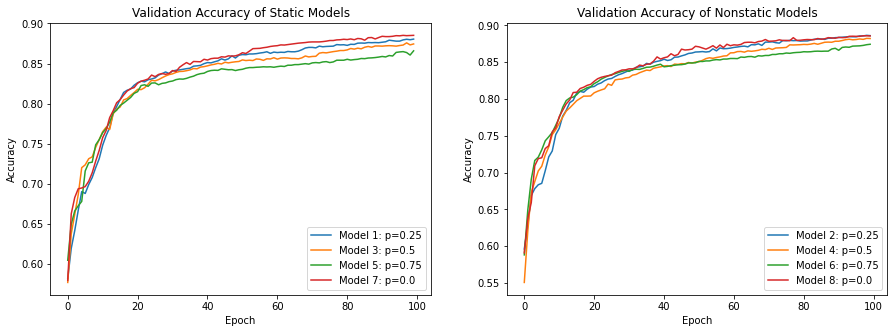

In [63]:
#Plotting validation accuracies

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(range(100), df1['val_acc'], label="Model 1: p=0.25")
axs[0].plot(df3['val_acc'], label="Model 3: p=0.5")
axs[0].plot(df5['val_acc'], label="Model 5: p=0.75")
axs[0].plot(df7['val_acc'], label="Model 7: p=0.0")
axs[0].set_title('Validation Accuracy of Static Models')
axs[1].plot(df2['val_acc'], label="Model 2: p=0.25")
axs[1].plot(df4['val_acc'], label="Model 4: p=0.5")
axs[1].plot(df6['val_acc'], label="Model 6: p=0.75")
axs[1].plot(df8['val_acc'], label="Model 8: p=0.0")
axs[1].set_title('Validation Accuracy of Nonstatic Models')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Accuracy')
    ax.legend(loc='lower right')

plt.show()

Above are plotted the validation accuracies for the static and nonstatic models.  It is interesting that the dropout probabilities seem to have a larger effect on the static models than the nonstatic models.  Perhaps the extra parameters in the nonstatic models help the model avoid overfitting and provide some sort of regularization, which makes dropout less necessary in these models.  Another important observation is that removing dropout (by setting the dropout probability to 0) results in better or equal validation accuracy by the end of training compared to the networks that included dropout.  However, since the validation accuracies are all still increasing after 100 epochs, perhaps more training would have revealed dropout to be important.  Thus, we must remain inconclusive as to whether dropout improved or hurt the performance of the network.

In [65]:
# Loading testing results

df_test_results = pd.read_pickle('/content/test_results.pkl')

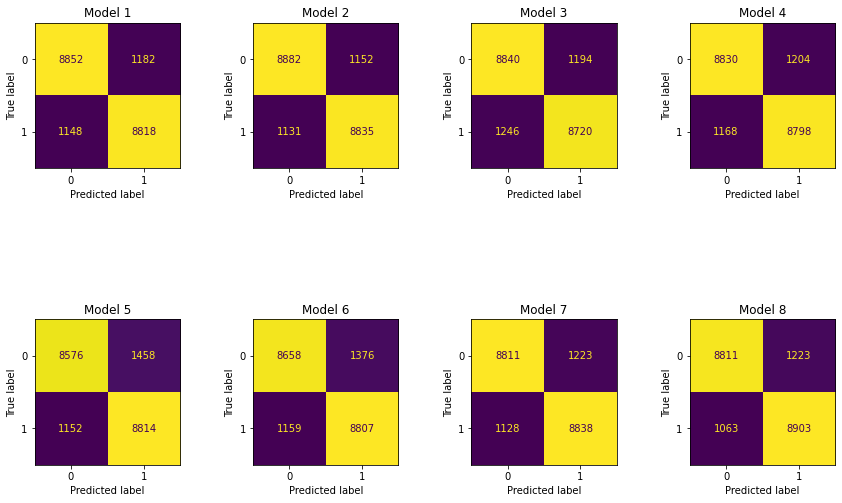

In [91]:
#Plotting confusion matrices

fig, axes = plt.subplots(2, 4, figsize=(15,10))

for ax, i in zip(axes.flat, range(8)):
    cm = df_test_results['Confusion Matrix'][i]
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax)
    ax.set_title(df_test_results['Model'][i])
    disp.im_.colorbar.remove()

plt.show()

Above are the confusion matrices on the testing data for each model.  It is clear that for each model, the false positive and false negative classifications are the same order of magnitude.  However, there does seem to be a bias in the network towards classifying movie reviews as positive, i.e., there are usually a few hundered more false positives than false negatives.  Recall in part 1 of the report that we found that positive reviews tended to be more polarizing than negative reviews.  Perhaps the networks have picked up on this feature and are using it too liberally in their classifications.

In [106]:
#Displaying test results

df_test_results.loc[:, :'F1 Score']

,Model,Accuracy,Precision Score,Recall Score,F1 Score
0,Model 1,0.88350,0.881800,0.884808,0.883302
1,Model 2,0.88585,0.884650,0.886514,0.885581
2,Model 3,0.87800,0.879564,0.874975,0.877264
3,Model 4,0.88140,0.879624,0.882802,0.881210
4,Model 5,0.86950,0.858061,0.884407,0.871035
5,Model 6,0.87325,0.864873,0.883705,0.874187
6,Model 7,0.88245,0.878442,0.886815,0.882608
7,Model 8,0.88570,0.879222,0.893337,0.886223


Above are the testing results for all of the models.  As can be seen, all the results are very similar.  The best performing model was model 8.  Recall that this model was nonstatic and with no dropout.  Therefore, we tenatively conclude that dropout is unecessary for this model.  Again, more training may have lead us to reject this conclusion.  A hypothesis for why dropout may not be needed in this network is that while it is very broad, it is not very deep, and we know that deep networks are more inclined to overfit.  Thus, regularization may not be as much of a problem for this network structure.  The worst models were 5 and 6.  Recall that these models had a high dropout probability of 0.75.  Thus, high dropout probability does not seem to correspond with better accuracy.  Perhaps these networks did not have enough capacity, as most of the neurons were killed during training.  Another important observation is that the nonstatic models (the even-numbered models) always performed better when dropout was held constant.  Therefore, we are relatively confident that nonstatic learning is superior to static learning.  This comports with the conclusions of the systematic study of nonstatic learning done in "A Sensitivity Analysis Of (And Practitioners' Guide To) Convolutional Neural Networks For Sentence Classification."  Regarding the recall, precision, and F1 scores, again it seems that having no dropout was superior, as model 8 beats almost all the other models.  With F1 scores near 0.9, we see that there seems to be a fairly good balance between precision and recall.  

## Discussion

Overall, it appears that dropout was not effective in our networks.  However, it does appear that nonstatic learning is preferable to static learning.  However, our conclusions are qualified by the fact that more training was required for all of the networks.  We were prohibited by time and resources.  It took about 90 minutes to train each network.  This was slower than others have achieved with this network structure.  We believe that a few changes in the data pipeline would have resulted in faster training.  In particular, we made the mistake of converting during training the list of words that comprise each review.  We should have converted the entire dataset to vectors before any training.  This way we would have avoided repeating this process 8 times (one for each network).  We were also a bit disappointed with the testing accuracies of all the networks, especially considering that the logistic tf-idf classifier trained in part 1 of the report performed better than many of the networks trained in this part.  However, we take solace in the fact that others have observed the same results.  In particular, it appears that the authors of "Character-level Convolutional Networks for Text Classification" have found that it requires very large quantities of data (upwards of a million data points) trained over tens of thousands of epochs in order to beat the performance of simple tf-idf-based classifiers.






## Conclusion

If we had more time and resources, we would have enjoyed exploring other text-based datasets.  If we had better computational resources, we would have liked to explore the skip-gram word embedding with higher dimensions.  Likewise, if we had more time for training, we would have liked to see how the networks in part 3 would have performed over 300 or more epochs.  These qualifications not withstanding, we still learned quite a lot while working on the 3 parts of this report.

## References:

The paper on which we based the overall architecture of the networks in this report is ["Convolutional Neural Networks for Sentence Classification"](https://arxiv.org/abs/1408.5882).  For more information on the effect of nonstatic learning, see the systematic study ["A Sensitivity Analysis Of (And Practitioners' Guide To) Convolutional Neural Networks For Sentence Classification"](https://arxiv.org/abs/1510.03820).  For more information on the effect of dataset sizes on performance compared to tf-idf based classifiers see ["Character-level Convolutional Networks for Text Classification"](https://arxiv.org/abs/1509.01626).

We were also greatly assisted by the github found [here](https://github.com/galsang/CNN-sentence-classification-pytorch) in our implementation of the networks in this part of the report.